Based on https://github.com/James-Jagielski/7-bit-D-A-converter-MP4-MADVLSI/blob/main/schematics/simulations/plot_dac_mc.ipynb with permission of repo owners

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from si_prefix import si_format

In [56]:
n_bits = 7
nano = 1e-9
results_dir = "./mc"


7.375418827440861e-08
[7.375418827440861e-08, 0]
max allowable error 3.6877094137204306e-08
max error 1.4344324533247322e-06
variance of error 1.4344324533247322e-06
-4.020548741251566
-11.864594438328801
-9.868838100416875
8.756439242791412
3.591593646592543
3.87242677212172
-1.4342220967347796
6.67593556044725
2.74484108502379
11.546967069755263
max overall dnl 8.327022723653124
loc of max value 698
INL [-4.020548741251566, -11.864594438328801, -9.868838100416875, 8.756439242791412, 3.591593646592543, 3.87242677212172, -1.4342220967347796, 6.67593556044725, 2.74484108502379, 11.546967069755263]
max overall inl 11.546967069755263


Text(0, 0.5, 'lsbs of error')

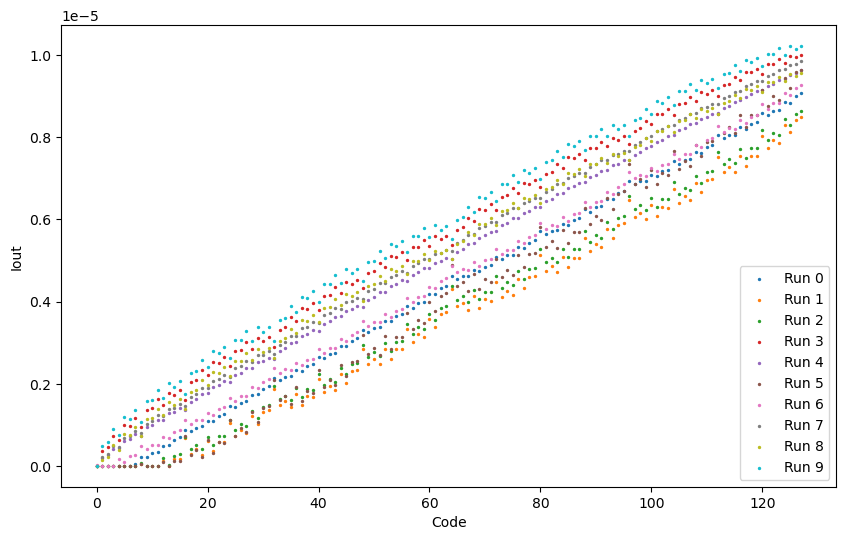

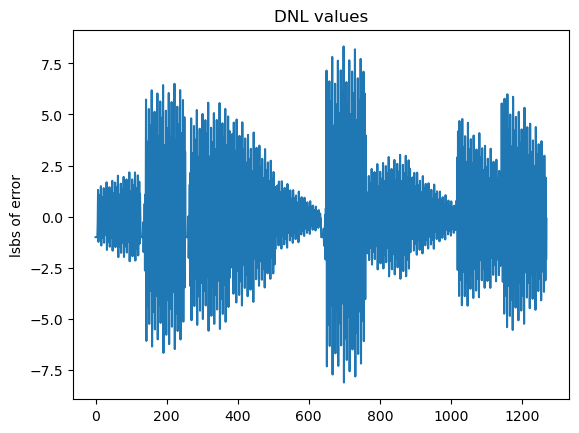

In [86]:
mc_simulations = []
endpoint_diff = []
for filename in os.listdir(results_dir):
    df = pd.read_csv(os.path.join(results_dir, filename), delimiter = "\s+")
    # print(df.head(3))
    #print(df)
    # df["code"] = df["v(b0)"] * 0 # init column to all 0s
    # for bit in range(n_bits):
    #     # df["code"] = df["code"] + (df[f"v{bit}"] > .5*df["vdd"]) * 2 ** (n_bits - bit - 1)
    #     df["code"] = df["code"] + (df[f"v(b{bit})"] > .5*1.8) * 2 ** (n_bits - bit - 1) #WHAT DOES THIS DO
    #     df.drop(f"v(b{bit})", axis = "columns", inplace = True)
    df["code"] = range(128)
    df.rename({"i(VI_out)": "Iout"}, axis = "columns", inplace = True)
    # print(df.head(10))
    mc_simulations.append(df)
    endpoint_diff.append(df["Iout"][127]-df["Iout"][0])

ideal_step_size = np.mean(endpoint_diff) / (2 ** n_bits)
print(ideal_step_size)
tdf = pd.concat(mc_simulations)
plt.figure(figsize = (10, 6))
plt.xlabel("Code")
plt.ylabel("Iout")

#z = np.polyfit(tdf["code"], tdf["Iout"], 1)
z = [ideal_step_size,0]
print(z)
p = np.poly1d(z)

errors = np.subtract(p(tdf["code"]),tdf["Iout"])

print("max allowable error", np.mean( np.subtract( p(range(1,128)) ,p(range(0,127)) ) )/2 )
print("max error",np.max(errors))
print("variance of error",np.max(errors))

dnl  = []
dnl_multi = []
inl = []
for df_simulation in mc_simulations:
    sorted = df_simulation.sort_values("code")
    current =   np.subtract(np.divide(
                    np.subtract(
                         list(sorted["Iout"])[1:],list(sorted["Iout"])[:-1]
                    ),ideal_step_size),1)
    current_inl = np.sum(current)
    print(current_inl)
    cc = list(current) #list(np.vstack((current,dnl)).T)
    #print(len(cc))
    dnl_multi.append(cc)
    inl.append(current_inl)
    for line in cc:
        dnl.append(line)#dnl.append(float(max(line,key=abs)))
    #print(dnl)

# plt.plot(range(128),p(range(128)),"k--", label = "trendline", linewidth = .5)

for i, df_simulation in enumerate(mc_simulations):
    # plt.plot(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), linewidth = 1, label = f"Run {i}")
    plt.scatter(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), s = 2, label = f"Run {i}")
plt.legend(loc = "lower right")

plt.figure()
plt.plot(range(len(dnl)), dnl)
plt.title("DNL values")
print("max overall dnl",max(dnl,key=abs)) 
print("loc of max value",dnl.index(max(dnl,key=abs)))
print("INL" , inl)
print("max overall inl", max(inl))
plt.ylabel("lsbs of error")